In [ ]:
#!pip install --upgrade pip
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets
# !pip install cubist

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d


In [2]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb
importing Jupyter notebook from Header.ipynb


In [3]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [4]:
#----------- Reading lab data, emit data and data having contaminated samples-----------------------------
df_lab = pd.read_csv('uae.csv')
df_sat = pd.read_csv('uae_emit.csv')
df_faulty = pd.read_csv('oil.csv')
df_faulty = df_faulty.T
df_faulty.columns = df_faulty.iloc[0,:].copy()
df_faulty = df_faulty.reset_index(drop=True)
df_faulty = df_faulty.iloc[1:, :].copy()
df_faulty.head(5)


#-------------Renaming columns---------------------------------------------------------------------------
df_sat.rename(columns= {'latitude':'long', 'longitude': 'lat'}, inplace=True)
df_lab.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)
df_faulty.rename(columns = {'Lon': 'long', 'Lat':'lat'}, inplace = True)

# obtaining faulty rows of df_lab using the data frame df_faulty ---------------------------------- 

faulty_rows =[]
(row, col) = df_lab.shape
for i in range (0, row):
    lat = df_lab.loc[i,'lat']
    long = df_lab.loc[i,'long']
    temp = df_faulty.loc[:,:][(df_faulty.loc[:,'lat'] == lat) & (df_faulty.loc[:,'long'] == long)]
    (r, c) = temp.shape
    if r != 0:
        faulty_rows.append(i)
        #print(r, c, 'at', i)

# removing faulty rows from lab data --------------------------------------------

clean_lab = df_lab.drop(df_lab.index[faulty_rows]).copy()

# obtaining faulty rows of df_sat using the data frame df_faulty ---------------------------------- 

faulty_rows =[]
(row, col) = df_sat.shape
for i in range (0, row):
    lat = df_sat.loc[i,'lat']
    long = df_sat.loc[i,'long']
    temp = df_faulty.loc[:,:][(df_faulty.loc[:,'lat'] == lat) & (df_faulty.loc[:,'long'] == long)]
    (r, c) = temp.shape
    if r != 0:
        faulty_rows.append(i)
        #print(r, c, 'at', i)

# removing faulty rows from satellite data --------------------------------------------

clean_sat = df_sat.drop(df_sat.index[faulty_rows]).copy()

FileNotFoundError: [Errno 2] No such file or directory: 'oil.csv'

In [5]:
# obtaining corresponding rows of clean_sat using clean_lab and removing extra rows -------------- 

missing_rows =[]
small_lab = clean_lab.iloc[0:91,:].copy()

(row, col) = clean_sat.shape
for i in range (0, row):
    lat = clean_sat.iloc[i, clean_sat.columns.get_loc('lat')]
    long = clean_sat.iloc[i, clean_sat.columns.get_loc('long')]
    temp = clean_lab.loc[:,:][(clean_lab.loc[:,'lat'] == lat) & (clean_lab.loc[:,'long'] == long)]
    (r, c) = temp.shape
    if r == 0:
        print('missing:', i)
        missing_rows.append(i)
        #print(r, c, 'at', i)
    else:
        #print(i)
        small_lab.iloc[i,:] = temp.iloc[0, :].copy()
        

small_lab = small_lab.drop(small_lab.index[missing_rows]).copy()
small_sat = clean_sat.drop(clean_sat.index[missing_rows]).copy()
small_sat.rename(columns = {'OM': 'TOC', 'Clay': 'clay', 'Silt':'silt', 'Sand': 'sand'}, inplace = True)
small_lab.reset_index()
small_sat.reset_index()

missing: 17
missing: 23
missing: 24
missing: 25
missing: 26
missing: 27
missing: 28
missing: 34
missing: 35
missing: 36
missing: 37
missing: 76
missing: 77


,index,siteID,long,lat,TOC,clay,silt,sand,380,field_30,field_31,field_32,field_33,field_34,field_35,field_36,field_37,field_38,field_39,field_40,field_41,field_42,field_43,field_44,field_45,field_46,field_47,field_48,field_49,field_50,field_51,field_52,field_53,field_54,field_55,field_56,field_57,field_58,field_59,field_60,field_61,field_62,field_63,field_64,field_65,field_66,field_67,field_68,field_69,field_70,...,field_264,field_265,field_266,field_267,field_268,field_269,field_270,field_271,field_272,field_273,field_274,field_275,field_276,field_277,field_278,field_279,field_280,field_281,field_282,field_283,field_284,field_285,field_286,field_287,field_288,field_289,field_290,field_291,field_292,field_293,field_294,field_295,field_296,field_297,field_298,field_299,field_300,field_301,field_302,field_303,field_304,field_305,field_306,field_307,field_308,field_309,field_310,field_311,field_312,2500
0,0,1.000477e+09,54.736553,24.236353,0.22,0,1,98,0.085279,0.103078,0.119389,0.128061,0.139497,0.147513,0.157616,0.166024,0.172308,0.179751,0.184417,0.190112,0.192551,0.197109,0.200987,0.206171,0.208703,0.215136,0.219219,0.223209,0.238644,0.245610,0.253334,0.261143,0.268370,0.274080,0.279507,0.286739,0.290540,0.294914,0.301314,0.303313,0.306471,0.307948,0.310113,0.314207,0.313678,0.316043,0.316784,0.322546,0.323707,0.321781,...,0.381557,0.383339,0.381944,0.376022,0.375299,0.374785,0.374884,0.373970,0.372653,0.363006,0.360191,0.364152,0.360713,0.356433,0.351265,0.344674,0.336427,0.328248,0.321351,0.314135,0.308051,0.300567,0.288437,0.281765,0.281981,0.272245,0.264620,0.261517,0.258588,0.252653,0.262771,0.279054,0.281331,0.281520,0.283016,0.284190,0.290145,0.289863,0.294918,0.297655,0.292699,0.298314,0.291055,0.307542,0.302529,0.303586,0.311486,0.314618,0.305380,0.306251
1,1,1.000479e+09,54.712263,24.253125,0.23,0,0,100,0.095742,0.112495,0.130376,0.139931,0.151900,0.161570,0.170378,0.181464,0.188669,0.195724,0.203087,0.207407,0.211207,0.215157,0.219232,0.225357,0.229552,0.236985,0.241751,0.246416,0.261957,0.271295,0.279114,0.288119,0.295020,0.302876,0.307202,0.314195,0.318614,0.323975,0.329800,0.333451,0.334598,0.336439,0.340032,0.343368,0.343443,0.346369,0.349389,0.351139,0.354192,0.351600,...,0.419961,0.420007,0.418705,0.411302,0.409515,0.411745,0.409702,0.407855,0.405273,0.396542,0.393083,0.396529,0.391254,0.388480,0.384077,0.376820,0.367789,0.361811,0.353310,0.347826,0.341289,0.331873,0.319151,0.311826,0.311019,0.301713,0.290808,0.290811,0.282853,0.277299,0.288809,0.305054,0.306081,0.302823,0.303849,0.305946,0.310530,0.304909,0.308455,0.314349,0.305711,0.309247,0.301614,0.315456,0.312557,0.308048,0.320274,0.329963,0.316631,0.315508
2,2,1.000415e+10,54.628437,24.201236,0.54,7,2,71,0.064699,0.079748,0.093937,0.108489,0.117750,0.126760,0.135200,0.144607,0.152155,0.160661,0.165652,0.170305,0.173636,0.177700,0.183130,0.187463,0.191430,0.198070,0.202003,0.205812,0.219405,0.226648,0.232805,0.240864,0.248926,0.254818,0.258564,0.268640,0.274822,0.277116,0.283489,0.281647,0.283578,0.285467,0.288019,0.291512,0.292414,0.294705,0.296773,0.297871,0.300137,0.298440,...,0.314016,0.313931,0.311449,0.310063,0.310373,0.308185,0.307276,0.304950,0.301883,0.297657,0.293346,0.293629,0.287712,0.287582,0.282814,0.277574,0.269995,0.265377,0.262489,0.256309,0.252780,0.245375,0.238564,0.233410,0.232323,0.226243,0.218207,0.213594,0.208011,0.201215,0.207993,0.211229,0.207827,0.207896,0.208781,0.210196,0.205057,0.203889,0.212144,0.217448,0.205543,0.206459,0.202270,0.230057,0.221015,0.221503,0.229943,0.230115,0.222726,0.223221
3,3,1.000420e+10,54.637328,24.167353,0.06,0,1,74,0.094205,0.113457,0.127322,0.140343,0.149630,0.160017,0.169573,0.178083,0.187471,0.195981,0.203694,0.208059,0.212508,0.215272,0.221710,0.227274,0.232255,0.238198,0.243768,0.247988,0.264663,0.272191,0.280134,0.289358,0.297756,0.305137,0.311293,0.319733,0.324489,0.329090,0.336048,0.337790,0.339947,0.340647,0.343244,0.347793,0.350534,0.351848,0.351879,0.354075,0.358630,0.355697,...,0.398944,0.

### Extracting spectra from small_sat and small_lab

In [6]:
min_loc_sat = small_sat.columns.get_loc('field_30')
max_loc_sat = small_sat.columns.get_loc('field_312')
small_sat_spec = small_sat.iloc[:, min_loc_sat: max_loc_sat+1].copy()
small_sat_spec.shape

(78, 283)

In [9]:
min_loc_lab = small_lab.columns.get_loc('380')
max_loc_lab = small_lab.columns.get_loc('2500')
small_lab_spec = small_lab.iloc[:, min_loc_lab: max_loc_lab].copy()
small_lab_spec.shape

(78, 2120)

### Resampling small_lab_spec into 283 bands

In [11]:
sampled_lab_spec = resample_spectra(small_lab_spec, 283)
sampled_lab_spec.shape

(78, 283)

### Renaming columns of sampled_sat_spec using columns of sampled_lab_spec

In [12]:
header = list(sampled_lab_spec.columns.values)
sampled_sat_spec = small_sat_spec.copy()
sampled_sat_spec.columns = header
sampled_sat_spec

,383,391,398,406,413,421,428,436,443,451,458,466,473,481,488,496,503,511,518,526,533,541,548,556,563,571,578,586,593,600,608,615,623,630,638,645,653,660,668,675,683,690,698,705,713,720,728,735,743,750,...,2129,2136,2144,2151,2159,2166,2174,2181,2189,2196,2204,2211,2219,2226,2234,2241,2249,2256,2264,2271,2279,2286,2293,2301,2308,2316,2323,2331,2338,2346,2353,2361,2368,2376,2383,2391,2398,2406,2413,2421,2428,2436,2443,2451,2458,2466,2473,2481,2488,2496
0,0.103078,0.119389,0.128061,0.139497,0.147513,0.157616,0.166024,0.172308,0.179751,0.184417,0.190112,0.192551,0.197109,0.200987,0.206171,0.208703,0.215136,0.219219,0.223209,0.238644,0.245610,0.253334,0.261143,0.268370,0.274080,0.279507,0.286739,0.290540,0.294914,0.301314,0.303313,0.306471,0.307948,0.310113,0.314207,0.313678,0.316043,0.316784,0.322546,0.323707,0.321781,0.326667,0.337015,0.345555,0.351591,0.359500,0.367306,0.376978,0.384723,0.388411,...,0.379285,0.381557,0.383339,0.381944,0.376022,0.375299,0.374785,0.374884,0.373970,0.372653,0.363006,0.360191,0.364152,0.360713,0.356433,0.351265,0.344674,0.336427,0.328248,0.321351,0.314135,0.308051,0.300567,0.288437,0.281765,0.281981,0.272245,0.264620,0.261517,0.258588,0.252653,0.262771,0.279054,0.281331,0.281520,0.283016,0.284190,0.290145,0.289863,0.294918,0.297655,0.292699,0.298314,0.291055,0.307542,0.302529,0.303586,0.311486,0.314618,0.305380
1,0.112495,0.130376,0.139931,0.151900,0.161570,0.170378,0.181464,0.188669,0.195724,0.203087,0.207407,0.211207,0.215157,0.219232,0.225357,0.229552,0.236985,0.241751,0.246416,0.261957,0.271295,0.279114,0.288119,0.295020,0.302876,0.307202,0.314195,0.318614,0.323975,0.329800,0.333451,0.334598,0.336439,0.340032,0.343368,0.343443,0.346369,0.349389,0.351139,0.354192,0.351600,0.354557,0.362672,0.371446,0.375335,0.381613,0.387654,0.400647,0.408319,0.411570,...,0.414457,0.419961,0.420007,0.418705,0.411302,0.409515,0.411745,0.409702,0.407855,0.405273,0.396542,0.393083,0.396529,0.391254,0.388480,0.384077,0.376820,0.367789,0.361811,0.353310,0.347826,0.341289,0.331873,0.319151,0.311826,0.311019,0.301713,0.290808,0.290811,0.282853,0.277299,0.288809,0.305054,0.306081,0.302823,0.303849,0.305946,0.310530,0.304909,0.308455,0.314349,0.305711,0.309247,0.301614,0.315456,0.312557,0.308048,0.320274,0.329963,0.316631
2,0.079748,0.093937,0.108489,0.117750,0.126760,0.135200,0.144607,0.152155,0.160661,0.165652,0.170305,0.173636,0.177700,0.183130,0.187463,0.191430,0.198070,0.202003,0.205812,0.219405,0.226648,0.232805,0.240864,0.248926,0.254818,0.258564,0.268640,0.274822,0.277116,0.283489,0.281647,0.283578,0.285467,0.288019,0.291512,0.292414,0.294705,0.296773,0.297871,0.300137,0.298440,0.298741,0.302826,0.305834,0.306730,0.309219,0.309687,0.314805,0.316398,0.318337,...,0.310132,0.314016,0.313931,0.311449,0.310063,0.310373,0.308185,0.307276,0.304950,0.301883,0.297657,0.293346,0.293629,0.287712,0.287582,0.282814,0.277574,0.269995,0.265377,0.262489,0.256309,0.252780,0.245375,0.238564,0.233410,0.232323,0.226243,0.218207,0.213594,0.208011,0.201215,0.207993,0.211229,0.207827,0.207896,0.208781,0.210196,0.205057,0.203889,0.212144,0.217448,0.205543,0.206459,0.202270,0.230057,0.221015,0.221503,0.229943,0.230115,0.222726
3,0.113457,0.127322,0.140343,0.149630,0.160017,0.169573,0.178083,0.187471,0.195981,0.203694,0.208059,0.212508,0.215272,0.221710,0.227274,0.232255,0.238198,0.243768,0.247988,0.264663,0.272191,0.280134,0.289358,0.297756,0.305137,0.311293,0.319733,0.324489,0.329090,0.336048,0.337790,0.339947,0.340647,0.343244,0.347793,0.350534,0.351848,0.351879,0.354075,0.358630,0.355697,0.356166,0.360509,0.364028,0.366398,0.366411,0.365637,0.371918,0.376381,0.377921,...,0.396204,0.398944,0.398908,0.396823,0.393620,0.388710,0.390765,0.388326,0.384845,0.379782,0.374320,0.369405,0.369012,0.364894,0.360347,0.356448,0.348087,0.340191,0.333558,0.327983,0.320114,0.312698,0.304634,0.289725,0.282544,0.281570,0.272581,0.261620,0.261488,0.257898,0.248206,0.262402,0.270839,0.273389,0.277806,0.275085,0.273093,0.277984,0.279436,0.285116,0.279536,0.

### Obtaining faulty bands using sampled_sat_spec

<Axes: >

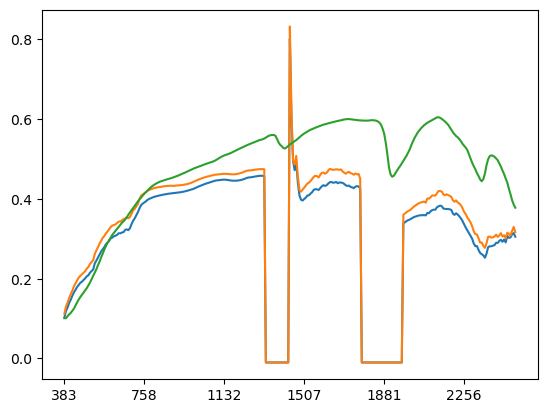

In [13]:
for i in range (0,2,1):
    sampled_sat_spec.iloc[i,:].plot()
sampled_lab_spec.iloc[1,:].plot()

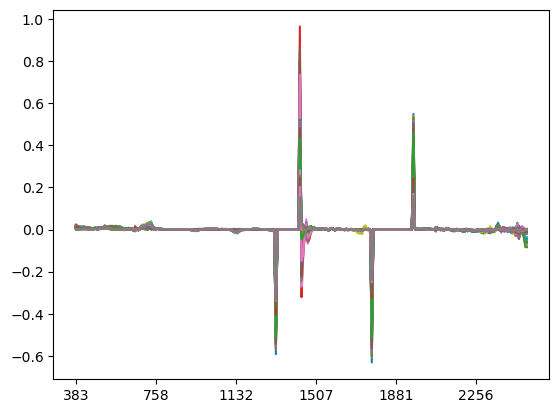

In [14]:
fod_sat = fod(sampled_sat_spec)
fod_sat
for i in range (0,78,1):
    fod_sat.iloc[i,:].plot()

,1320,1432,1440,1447,1769,1964
1,-0.484533,0.842585,-0.20953,-0.126529,-0.461067,0.370448


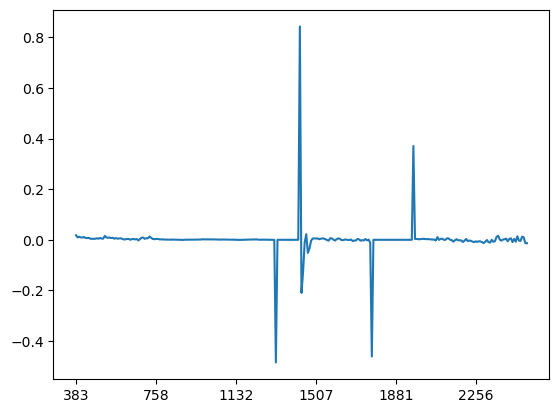

In [15]:
fod_sat.iloc[1,:].plot()

fod_sat1 = fod_sat.iloc[[1],:].copy()
b_col = (abs(fod_sat1) >=0.1).any()
fod_sat1 = fod_sat1.loc[: , b_col]
fod_sat1
#fod_sat1.columns.get_loc('1964')

In [16]:
# Select faulty column based on condition (i,e. boundary columns-- [1320/125:1447/142] + [1769/185:1964/211])-
faulty_columns = list(np.arange(125,146,1)) + list(np.arange(185,212,1))
print(faulty_columns)


[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]


## Dropping faulty bands from sampled_sat_spec and sampled_lab_spec

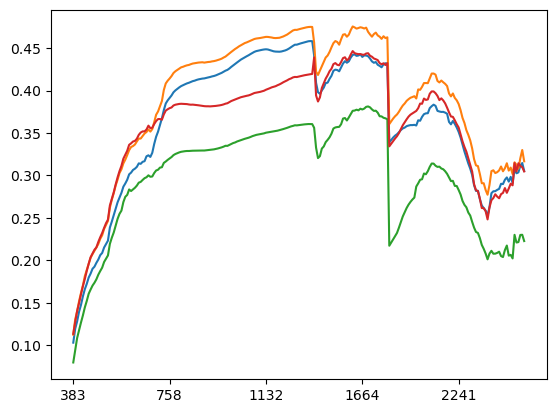

In [18]:
sat_spec = sampled_sat_spec.drop(sampled_sat_spec.columns[faulty_columns], axis=1).copy()
sat_spec.shape

for i in range (0,4,1):
    sat_spec.iloc[i,:].plot()

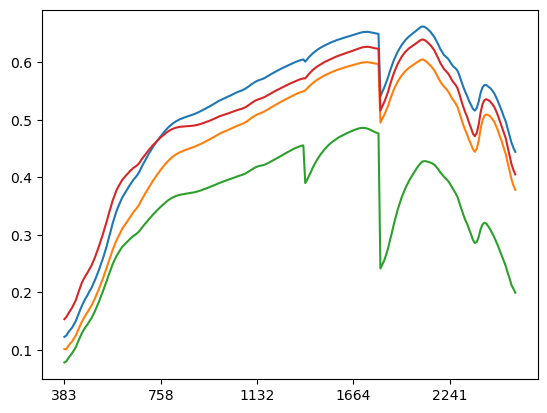

In [19]:
lab_spec = sampled_lab_spec.drop(sampled_lab_spec.columns[faulty_columns], axis=1).copy()
lab_spec.shape
for i in range (0,4,1):
    lab_spec.iloc[i,:].plot()

# Step 0: Setting up decision paramenters (Data Tree)

In [ ]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 3, 5, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 20, 50, 100, 200, 500]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']


# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

In [ ]:
min_loc_lab = clean_lab.columns.get_loc('380')
max_loc_lab = clean_lab.columns.get_loc('2500')
clean_lab_spec = clean_lab.iloc[:, min_loc_lab: max_loc_lab+1].copy()
clean_lab_spec.head(5)

#--- following 'spectra' is the spectrum after noise removal and faulty rows ----------------------
spectra = clean_lab_spec.copy()
spectra.head(5)
#spectra.shape

#-----following lab_spectra and sat_spectra are after removal of faulty bands
lab_spectra= lab_spec.copy()
sat_spectra= sat_spec.copy()

In [ ]:
sat_spec.shape

In [ ]:
# Based on removed noise (i.e, the clipping conditions) 

#---- AFTER REMOVAL OF NOISY WAVELENGTH ---------------------------------------------------- 
# --- loc locations (loc_min, loc_max) for chosen wavelengths (for use in df.loc )----------
# --- minimum and maximum iloc locations (roi_min, roi_max)       (for use in df.iloc )----------

min_wav = 380
max_wav = 2500

roi_min = spectra.columns.get_loc('380')
roi_max = spectra.columns.get_loc('2500')

In [ ]:
lab_spec2 = {}
for i in window_lengths:
    lab_spec2[i] = filt_sg(lab_spectra, i, 'sg2')
    
# sat_spec smoothed using sgsmooth function----  
sat_spec1 = {}
for i in window_lengths:
    sat_spec1[i] = sgsmooth(sat_spectra, i)    

In [ ]:
for i in range (0,4,1):
    sat_spec1[3].iloc[i,:].plot()

## First Order Derivative

# Step 1b: Target  Preprocessing (Outliers removal and Normalization)

In [ ]:
#df = pd.read_csv('uae.csv')
df = clean_lab.copy()
df_sat = small_sat.copy()
df_lab = small_lab.copy()

# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names)
T_lab = isolate_targets(df_lab,target_names)
T_sat = isolate_targets(df_sat,target_names)



# --- TODO : Also define and Use other normalisation methods ----
def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)
NT_lab = normalize_targets(T_lab)
NT_sat = normalize_targets(T_sat)




In [ ]:
sat_spec

## PLSR on sat_spec and lab_spec (evaluating using leave one out method)

In [ ]:
def plsr_iqrp (spectra, target, n_comp):
    
    full_spec = spectra.copy()
    
    rand_st, err = best_split (full_spec, target,0.2)
    print(rand_st)

    X_train, X_test, y_train, y_test = train_test_split(full_spec, target, test_size= 0.2, random_state= rand_st)
        
    Model = PLSRegression(n_components=n_comp, scale=True)
        
    Model.fit(X_train, y_train)
    y_pred = Model.predict(X_test, copy=True)
    
    
    iqrp_test = iqrp(y_pred, y_test)  
           
    return (iqrp_test)


In [ ]:
iqrp_sat = plsr_iqrp(sat_spec, T_sat[0], 6)
iqrp_sat

In [ ]:
from sklearn import linear_model

def plsr_avg_acc (spectra, target, n_comp):
    
    (r,c) = spectra.shape
    
    Y_test = target.copy()
    Y_pred = target.copy()
    
    #print('Y_test:', Y_test) 
    for i in range (0,r): 
        full_spec = spectra.copy()
        X_train = full_spec.drop(full_spec.index[i], axis=0)
        X_test = full_spec.iloc[[i],:].copy()
        full_tar = target.copy()
        y_train = full_tar.drop(full_tar.index[i], axis=0)
        y_test = full_tar.iloc[i].copy() 
               
        Model = PLSRegression(n_components=n_comp, scale=True)
        
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        Y_pred.iloc[i] = y_pred
        
    #print('Y_pred:', Y_pred)    
    
    avg_iqrp = np.round(iqrp (Y_pred, Y_test),2)
    avg_r2   = np.round(r2_score (Y_test, Y_pred),2)
    avg_rpd  = np.round(rpd (Y_pred, Y_test),2)
    
    print('IQRP:', avg_iqrp, 'R2_score:',  avg_r2, 'RPD:', avg_rpd)
    return 
        

In [ ]:
 plsr_avg_acc (sat_spec, T_sat[0], 6)

In [ ]:
 plsr_avg_acc (lab_spec, T_lab[0], 6)

In [ ]:
(iqrp_lab, rmse_lab) =plsr_avg_acc (lab_spec, T_lab[0], 6)
print(np.round(iqrp_lab,2), np.round(rmse_lab,2)) 

In [ ]:
(iqrp_clean_lab, rmse_clean) =plsr_avg_acc (spectra, T[0], 5)
print(np.round(iqrp_clean_lab,2),np.round(rmse_clean,2)) 

## Correlation between  (lab_spectra / sat_spectra) and targets (at different n_bands)

In [ ]:
T_lab[1].shape
lab_spec2[1].shape

In [ ]:
plt.style.use(['science','notebook','grid'])
# Pearson corelation between different wavelengths and Targets/Outputs (i.e, sand, clay, silt, and TOC) 

def find_rpval (spectra, T):
    r_val = []
    p_val = []
    r, c = spectra.shape
    for i in range (0,len(T)):
        p_val.append(spectra.loc[[0],:].copy())
        r_val.append(spectra.loc[[0],:].copy())
        for j in range(0, c):
            r_val[i].iloc[0,j], p_val[i].iloc[0,j] = stats.pearsonr(T[i], spectra.iloc[:, j])
    return(r_val, p_val)

#r_val, p_val = find_rpval (spec2[51], T)
# r_lab, p_lab = find_rpval (lab_spectra, T_lab)
# r_sat, p_sat = find_rpval (sat_spectra, T_sat)


# light_blue = '#6495ED'
# spec_std = 4*spec2[51].std()
# mean_spec_std = spec_std.copy()
# mean_spec_std.iloc[:] = spec_std.mean()

def plot_corr (target, lab_or_sat, n_bands):
    i = target_names.index(target)
    
    r_lab, p_lab = find_rpval (resample_spectra(lab_spectra, n_bands), T_lab)
    r_sat, p_sat = find_rpval (resample_spectra(sat_spectra, n_bands), T_sat)
    
    if lab_or_sat == 'lab':
        r_lab[i].iloc[0,:].plot(color = clr[i])
    else:
        r_sat[i].iloc[0,:].plot(color = clr[i])
    plt.ylim([-0.6, 0.6])

ipywidgets.interact(plot_corr, target = target_names, lab_or_sat = ['lab', 'sat'], n_bands = nbands_sampling)


# def plot_corr (target, mean_of_std):
#     i = target_names.index(target)
#     r_val[i].iloc[0,:].plot(color = clr[i])
#     spec_std.plot(color = 'blue')
#     if mean_of_std == 'on':
#         mean_spec_std.plot(color = 'blue', linewidth=1, linestyle='dashed')
#     plt.ylim([-0.6, 0.6])

# ipywidgets.interact(plot_corr, target = target_names, mean_of_std= ['on', 'off'])

### Correlation between  lab_spectra and sat_spectra

In [ ]:
def plot_corr_spectras (spectra1, spectra2):
    r, c = spectra1.shape
    r_val = spectra1.loc[[0],:].copy()
    p_val = spectra1.loc[[0],:].copy()
    
    for j in range(0, c):
            r_val.iloc[0,j], p_val.iloc[0,j] = stats.pearsonr(spectra1.iloc[:, j], spectra2.iloc[:, j])
    
    r_val.iloc[0,:].plot()
    
    plt.ylim([-1, 1])
    
    return()
    
def lab_sat_band_corr (n_bands):
    
    plot_corr_spectras (resample_spectra (lab_spectra, n_bands), resample_spectra (sat_spectra, n_bands))
    
    return()
    
#plot_corr_spectras (resample_spectra (lab_spectra, 10), resample_spectra (sat_spectra, 10))    

ipywidgets.interact(lab_sat_band_corr, n_bands = nbands_sampling)


## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [ ]:
sampled_spec = {}
for w in nbands_sampling:
    sampled_spec[w] = resample_spectra (spectra, w)

In [ ]:
for i in range (0,5,1):
    sampled_spec[200].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [ ]:
sampled_cr = {}
for w in nbands_sampling:
    sampled_cr[w] = resample_spectra (cr_spec, w)

In [ ]:
for i in range (0,5,1):
    sampled_cr[200].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [ ]:
sampled_fod = {}
for w in nbands_sampling:
    sampled_fod[w] = resample_spectra (fod_spec, w)

In [ ]:
for i in range (0,5,1):
    sampled_fod[200].iloc[i,:].plot()

## Correlation between wavelengths and Targets

In [ ]:
plt.style.use(['science','notebook','grid'])
# Pearson corelation between different wavelengths and Targets/Outputs (i.e, sand, clay, silt, and TOC) 

def find_rpval (spectra, T):
    r_val = []
    p_val = []
    for i in range (0,len(T)):
        p_val.append(spectra.loc[[0],:].copy())
        r_val.append(spectra.loc[[0],:].copy())
        for j in range(roi_min, roi_max+1):
            r_val[i].iloc[0,j], p_val[i].iloc[0,j] = stats.pearsonr(T[i], spectra.iloc[:, j])
    return(r_val, p_val)

r_val, p_val = find_rpval (spec2[51], T)

light_blue = '#6495ED'
spec_std = 4*spec2[51].std()
mean_spec_std = spec_std.copy()
mean_spec_std.iloc[:] = spec_std.mean()

def plot_corr (target, mean_of_std):
    i = target_names.index(target)
    r_val[i].iloc[0,:].plot(color = clr[i])
    spec_std.plot(color = 'blue')
    if mean_of_std == 'on':
        mean_spec_std.plot(color = 'blue', linewidth=1, linestyle='dashed')
    plt.ylim([-0.6, 0.6])

ipywidgets.interact(plot_corr, target = target_names, mean_of_std= ['on', 'off'])

# Step 2:  Parameters for Best Train-Test Split  

In [ ]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.2

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

# Step 3: Parameters for Best Model Fit 

## PLSR

In [ ]:

from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = iqrp(y_pred, y_test)
#         r2_test = r2_score(y_test, y_pred)
#         rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
               
        iqrpL.append(iqrp_test)
#         r2L.append(r2_test)
#         rpdL.append(rpd_test)
        
        
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
    
#     R2 = max(r2L)
#     n_r2 = r2L.index(R2)+1    
#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
#    print('IQRP :', IQRP,  'R2 :', R2,  'RPD:', RPD, '>>> n_comp: ', n_iqrp, n_r2, n_rpd)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [ ]:
import os
os.system('say "your program has finished"')
import time

In [ ]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest',  'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [ ]:
max_n_comp = 5

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        
        if t == 'sand' and m == 'mult':
            os.system('say "tree for multilinear running on sand"')
            print('tree for multilinear running on sand')
        if t == 'silt' and m == 'mult':
            os.system('say "tree for multilinear running on silt"')
            print('tree for multilinear running on silt')
        if t == 'clay' and m == 'mult':
            os.system('say "tree for multilinear running on clay"')
            print('tree for multilinear running on clay')
        if t == 'TOC' and m == 'mult':
            os.system('say "tree for multilinear running on TOC"')
            print('tree for multilinear running on TOC')
            
        if t == 'sand' and m == 'plsr':
            os.system('say "tree for plsr running on sand"')
            print('tree for plsr running on sand')
        if t == 'silt' and m == 'plsr':
            os.system('say "tree for plsr running on silt"')
            print('tree for plsr running on silt')
        if t == 'clay' and m == 'plsr':
            os.system('say "tree for plsr running on clay"')
            print('tree for plsr running on clay')
        if t == 'TOC' and m == 'plsr':
            os.system('say "tree for plsr running on TOC"')
            print('tree for plsr running on TOC')
            
        if t == 'sand' and m == 'randomforest':
            os.system('say "tree for randomforest running on sand"')
            print('tree for randomforest running on sand')
        if t == 'silt' and m == 'randomforest':
            os.system('say "tree for randomforest running on silt"')
            print('tree for randomforest running on silt')
        if t == 'clay' and m == 'randomforest':
            os.system('say "tree for randomforest running on clay"')
            print('tree for randomforest running on clay')
        if t == 'TOC' and m == 'randomforest':
            os.system('say "tree for randomforest running on TOC"')    
            print('tree for randomforest running on TOC')
            
        if t == 'sand' and m == 'cubist':
            os.system('say "tree for cubist running on sand"')
            print('tree for cubist running on sand')
        if t == 'silt' and m == 'cubist':
            os.system('say "tree for cubist running on silt"')
            print('tree for cubist running on silt')
        if t == 'clay' and m == 'cubist':
            os.system('say "tree for cubist running on clay"')
            print('tree for cubist running on clay')
        if t == 'TOC' and m == 'cubist':
            os.system('say "tree for cubist running on TOC"')
            print('tree for cubist running on TOC')
            
        if t == 'sand' and m == 'svr':
            os.system('say "tree for svr running on sand"')
            print('tree for svr running on sand')
        if t == 'silt' and m == 'svr':
            os.system('say "tree for svr running on silt"')
            print('tree for svr running on silt')
        if t == 'clay' and m == 'svr':
            os.system('say "tree for svr running on clay"')
            print('tree for svr running on clay')
        if t == 'TOC' and m == 'svr':
            os.system('say "tree for svr running on TOC"')
            print('tree for svr running on TOC')
            
        if t == 'sand' and m == 'ridge':
            os.system('say "tree for ridge running on sand"')
            print('tree for ridge running on sand')
        if t == 'silt' and m == 'ridge':
            os.system('say "tree for ridge running on silt"')
            print('tree for ridge running on silt')
        if t == 'clay' and m == 'ridge':
            os.system('say "tree for ridge running on clay"')
            print('tree for ridge running on clay')
        if t == 'TOC' and m == 'ridge':
            os.system('say "tree for ridge running on TOC"')
            print('tree for ridge running on TOC')
            
            
        if t == 'sand' and m == 'gbrt':
            os.system('say "tree for gbrt running on sand"')
            print('tree for gbrt running on sand')
        if t == 'silt' and m == 'gbrt':
            os.system('say "tree for gbrt running on silt"')
            print('tree for gbrt running on silt')
        if t == 'clay' and m == 'gbrt':
            os.system('say "tree for gbrt running on clay"')
            print('tree for gbrt running on clay')
        if t == 'TOC' and m == 'gbrt':
            os.system('say "tree for gbrt running on TOC"')
            print('tree for gbrt running on TOC')     
                 
            
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    
                    #---- following case : either sampling or decision tree methods--
                    #---- in this case select appropriate sampled spectrum -------
                    if n!=0 or m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                        #------ case: sampling required-----------------------
                        Y = tree[t][tp][n][p]
                        
                        #------ setting spec to appropriate sampled spectra----
                        if p == 'none':
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_spec[n]
                        
                        elif p == 'fod':
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_fod[n]
                                
                        else:  
                            if n == 0:
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                #---- reached here with some n!=0----
                                spec = sampled_cr[n]
                        
                        #---- target selection and normalization ---
                        if tp == 'none':
                            y = T[target_names.index(t)]
                            rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                        else:
                            y = NT[target_names.index(t)]
                            rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                            #print('one more target set')
                            
                        #---- performing train-test split----------------------
                        X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                        #----- PLSR: best parameters, fitting, and prediction
                        if m == 'plsr':
                            n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                            #print('one more n_comp', n_com)
                            Model = PLSRegression(n_components=n_com, scale=True)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test, copy=True)
                            yhat_pred = Model.predict(X_train, copy=True)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['n_comp'] = n_com
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
                        #----- MULTILINEAR:  fitting, and prediction---------- 
                        if m == 'mult':
                            Model = linear_model.LinearRegression()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
                        #----- RANDOM_FOREST:   fitting, and prediction---------- 
                        if m == 'randomforest': 
                            Model = RandomForestRegressor(random_state= 20)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                       
                       #----- CUBIST REGRESSION:    fitting and prediction---------
                        if m == 'cubist':
                            Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                            
                      #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                        if m == 'svr': 
                            Model = SVR()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred 
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                     
                    #------ RIDGE REGRESSION: fitting and prediction-----------      
                        if m == 'ridge': 
                            Model = KernelRidge()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred 
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                            
                            
                   #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                        if m == 'gbrt': 
                            Model = GradientBoostingRegressor()
                            Model.fit(X_train, y_train)
                            y_pred = Model.predict(X_test)
                            yhat_pred = Model.predict(X_train)
                                
                            Y['test'] = y_test
                            Y['testP'] = y_pred
                            Y['train'] = y_train
                            Y['trainP'] = yhat_pred 
                            Y['iqrp_test'] = iqrp(y_pred, y_test)
                                      
                            
                            
                    #---- following case: no sampling needed and model is not tree based methods e.g. randomforest ---    
                    else: 
                        for sg in sg_filters:
                            tree[t][tp][n][p][sg] ={}
                            for w in window_lengths:
                                tree[t][tp][n][p][sg][w]={}
                                Y = tree[t][tp][n][p][sg][w]
                                
                                # -- optimal train test split----------------------------------------
                            
                                # -- deciding the smoothed spectra in present branch ---
                                if sg == 'sg1':
                                    spec = spec1[w]
                                else:
                                    spec = spec2[w]
                                
                                # -- preprocessing the spectra ------
                    
                                #--- no preprocessing ---------------
                                if p == 'none':
                                    spec = spec
                                
                                #--- first order derivative + smoothing------    
                                elif p == 'fod':
                                    if sg == 'sg1':
                                        spec = fod1[w]
                                    else:
                                        spec = fod2[w]
                                    #print('fod for one more case')
                                
                                #--- continuum removal + smoothing---------    
                                else: 
                                    if sg == 'sg1':
                                        spec = cr1[w]
                                    else:
                                        spec = cr2[w]
                                    #print('cr for one more case')
                            
                                
                                #---- target selection and normalization ---
                                if tp == 'none':
                                    y = T[target_names.index(t)]
                                    rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                                else:
                                    y = NT[target_names.index(t)]
                                    rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                                    #print('one more target set')
                            
                                #---- performing train-test split----------------------
                                X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                            
                                
                                #----- PLSR: best parameters, fitting, and prediction
                                if m == 'plsr':
                                    n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                                    #print('one more n_comp', n_com)
                                    Model = PLSRegression(n_components=n_com, scale=True)
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test, copy=True)
                                    yhat_pred = Model.predict(X_train, copy=True)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred
                                    Y['n_comp'] = n_com
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
                                #----- MULTILINEAR:  fitting, and prediction---------- 
                                if m == 'mult':
                                    Model = linear_model.LinearRegression()
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                                
#                                 #----- RANDOM_FOREST:   fitting, and prediction---------- 
#                                 if m == 'randomforest': 
#                                     Model = RandomForestRegressor(random_state= 20)
#                                     Model.fit(X_train, y_train)
#                                     y_pred = Model.predict(X_test)
#                                     yhat_pred = Model.predict(X_train)
                                
#                                     Y['test'] = y_test
#                                     Y['testP'] = y_pred
#                                     Y['train'] = y_train
#                                     Y['trainP'] = yhat_pred


                    
                                #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                                if m == 'svr': 
                                    Model = SVR(kernel = 'poly', degree =3, C = 0.0001)
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred  
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                                    
                         
                         #--------- RIDGE REGRESSION: fitting and prediction------------------
                                if m == 'ridge': 
                                    Model = KernelRidge()
                                    Model.fit(X_train, y_train)
                                    y_pred = Model.predict(X_test)
                                    yhat_pred = Model.predict(X_train)
                                
                                    Y['test'] = y_test
                                    Y['testP'] = y_pred
                                    Y['train'] = y_train
                                    Y['trainP'] = yhat_pred 
                                    Y['iqrp_test'] = iqrp(y_pred, y_test)
                            
                            
                      
     
    
    end = time.time()                            
    os.system('say "your program has finished"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Mtree initialisation (do not run below code every time)

In [ ]:
Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [ ]:
Mtree['plsr'] = build_tree_for ('plsr')

### Multiple Linear Regression Branch

In [ ]:
Mtree['mult'] = build_tree_for ('mult')

### Random Forest Branch

In [ ]:
Mtree['randomforest'] = build_tree_for ('randomforest')

### SVM Branch

In [ ]:
Mtree['svr'] = build_tree_for ('svr')

### GBRT Branch

In [ ]:
Mtree['gbrt'] = build_tree_for ('gbrt')

### Ridge Regression Branch

In [ ]:
Mtree['ridge'] = build_tree_for ('ridge')

### Cubist Branch

In [ ]:
Mtree['cubist'] = {}
#Mtree['cubist'] = build_tree_for ('cubist')

## Best of all worlds

In [ ]:
def best_model_parameters (Mtree, target, method):
    t=target
    m= method
    
    best_iqrp = 0
    best_sg ='NA'
    best_w = 'NA'
    best_n_comp = 'NA'
    
    if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
        for tp in prepare_target:
            for n in nbands_sampling:
                for p in prepare_spec:
                    Y = Mtree[m][t][tp][n][p]
                    cur_iqrp = Y['iqrp_test']
                    if cur_iqrp > best_iqrp:
                        best_iqrp = cur_iqrp
                        best_tp = tp
                        best_n = n
                        best_p = p
                        
                            
    else:
        for tp in prepare_target:
            for n in nbands_sampling:
                for p in prepare_spec:
                    for sg in sg_filters:
                        for w in window_lengths:
                            if n == 0:
                                Y = Mtree[m][t][tp][n][p][sg][w]
                            else:
                                Y = Mtree[m][t][tp][n][p]
                            cur_iqrp = Y['iqrp_test']
                            if cur_iqrp > best_iqrp:
                                best_iqrp = cur_iqrp
                                best_tp = tp
                                best_n = n
                                best_p = p
                                best_sg = sg
                                best_w = w
                                if m == 'plsr':
                                    best_n_comp = Y['n_comp']
    param_list = ['IQRP:', np.round(best_iqrp,2), 'pSpec:', best_p, 'bands:', best_n, 'pTar:', best_tp, 'filt:', best_sg, 'win:', best_w, 'best_n_comp: ', best_n_comp]                                 
    return (param_list)                                
    

In [ ]:
param_list = best_model_parameters (Mtree, 'sand', 'randomforest')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'sand', 'plsr')
print(param_list)

In [ ]:
# param_list = best_model_parameters (Mtree, 'sand', 'cubist')
# print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'sand', 'mult')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'sand', 'ridge')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'sand', 'svr')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'sand', 'gbrt')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'clay', 'plsr')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'silt', 'plsr')
print(param_list)

In [ ]:
param_list = best_model_parameters (Mtree, 'TOC', 'plsr')
print(param_list)

## Plotting Model Accuracy (ipywidgets)

In [ ]:
def plot_model_acc (target, method, smth_filt, window_len, spec_preprocessing, n_bands, target_preprocessing):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    sg = smth_filt
    w = window_len
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    if n!=0 or m == 'randomforest' or m =='cubist' or m == 'gbrt':
        Y = Mtree[m][t][tp][n][p]
    else: 
        Y = Mtree[m][t][tp][n][p][sg][w]
    
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    iqrp_test = iqrp(y_pred, y_test)
    r2_test = r2_score(y_test, y_pred)
    rpd_test = y_test.std()/np.sqrt(mean_squared_error(y_test, y_pred))
    
    iqrp_train = iqrp(yhat_pred, y_train)
    r2_train = r2_score(y_train, yhat_pred)
    rpd_train = y_train.std()/np.sqrt(mean_squared_error(y_train, yhat_pred))
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[0].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    axes[1].text(0.95, 0.10, 'smoothing window={:.2f}'.format(w), transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 12)
        
    

In [ ]:
ipywidgets.interact(plot_model_acc, target = target_names, method = ml_methods, smth_filt = sg_filters, 
                    window_len = window_lengths, spec_preprocessing = prepare_spec, n_bands = nbands_sampling, 
                    target_preprocessing = prepare_target)

In [ ]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 3, 5, 7, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svm']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']